# Initial model for individual fitting (the first stage, add time variable para)

In [12]:
from scipy.integrate import solve_ivp   
from scipy.optimize import curve_fit, least_squares
from datetime import datetime
import warnings
import pandas as pd
import numpy as np
import pandas as pd
import os


# λ(t) 候选函数
def lambda_logistic(a, t):   # a = [L, k, t0]
    return a[0] / (1.0 + np.exp(-a[1]*(t - a[2])))

def lambda_exp_tail(a, t):   # a = [b0, k, c]
    return a[0] + np.exp(-a[1]*(t + a[2]))

# κ(t) 候选函数
def kappa_sym_logit(a, t):   # a = [K, k, t0], 形状 ~ 1/(exp(k(t-t0))+exp(-k(t-t0)))
    return a[0] / (np.exp(a[1]*(t - a[2])) + np.exp(-a[1]*(t - a[2])))

def kappa_gauss(a, t):       # a = [A, k, t0]
    return a[0] * np.exp(-(a[1]*(t - a[2]))**2)

def kappa_exp_tail(a, t):    # a = [b0, k, c]
    return a[0] + np.exp(-a[1]*(t + a[2]))

def _finite_rate(series, t, denom, clip_upper=None, drop_zeros=True):
    dt = np.median(np.diff(t))
    rate = np.diff(series) / dt
    rate = rate / denom[1:]
    x = t[1:].astype(float)

    rate = rate.astype(float)
    rate[np.isinf(rate) | np.isnan(rate)] = np.nan
    if clip_upper is not None:
        rate[np.abs(rate) > clip_upper] = np.nan
    if drop_zeros:
        if np.sum(rate == 0) / rate.size < 0.5:
            rate[rate == 0] = np.nan
    mask = ~np.isnan(rate)
    return x[mask], rate[mask]

def prefit_lambda(tTarget, Q, R, guess_3):
    # 若 R 很少，不做预拟合，返回 logistic 作为默认
    if (np.max(R) if len(R) else 0) < 20:
        return np.array(guess_3, float), lambda_logistic
    x, y = _finite_rate(R, tTarget, Q, clip_upper=1.0)
    if len(y) < 5:
        return np.array(guess_3, float), lambda_logistic

    # 试两种形式，择优
    cands = [(lambda_logistic, [0,0,0], [1, 5, 100]),
             (lambda_exp_tail, [0,0,0], [1, 5, 100])]
    best = None
    for fun, lb, ub in cands:
        def res(a): return fun(a, x) - y
        try:
            out = least_squares(res, x0=guess_3, bounds=(lb, ub), xtol=1e-6, ftol=1e-6, verbose=0)
            if best is None or out.cost < best[0]:
                best = (out.cost, out.x, fun)
        except Exception:
            pass
    if best is None:
        return np.array(guess_3, float), lambda_logistic
    return best[1], best[2]

def prefit_kappa(tTarget, Q, D, guess_3):
    if (np.max(D) if len(D) else 0) < 10:
        return np.array(guess_3, float), kappa_sym_logit
    x, y = _finite_rate(D, tTarget, Q, clip_upper=3.0)
    if len(y) < 5:
        return np.array(guess_3, float), kappa_sym_logit

    cands = [(kappa_sym_logit, [0,0,0], [1, 5, 100]),
             (kappa_gauss,     [0,0,0], [1, 5, 100]),
             (kappa_exp_tail,  [0,0,0], [1, 5, 100])]
    best = None
    for fun, lb, ub in cands:
        def res(a): return fun(a, x) - y
        try:
            out = least_squares(res, x0=guess_3, bounds=(lb, ub), xtol=1e-6, ftol=1e-6, verbose=0)
            if best is None or out.cost < best[0]:
                best = (out.cost, out.x, fun)
        except Exception:
            pass
    if best is None:
        return np.array(guess_3, float), kappa_sym_logit
    return best[1], best[2]                    

def seird_ode_timevary(t, y, alpha, beta, delta, lambda_coef, kappa_coef, Npop,
                       lambda_fun, kappa_fun):
    S, E, I, Q, R, D = y
    lam = float(lambda_fun(lambda_coef, t))
    kap = float(kappa_fun(kappa_coef, t))
    dS = -(beta * S * I + beta * 0.5 * S * Q) / Npop
    dE = -dS - alpha * E
    dI = alpha * E - delta * I
    dQ = delta * I - (lam + kap) * Q
    dR = lam * Q
    dD = kap * Q
    return [dS, dE, dI, dQ, dR, dD]


def euler_seird_solver(alpha, beta, delta, lambda_params, kappa_params,
                                   Npop, y0, t_full, lambda_fun = lambda_logistic, kappa_fun = kappa_gauss):
    """
    使用欧拉法(dt=1)求解SEIRD模型
    """
    # 初始化
    n_steps = len(t_full)
    dt = 1  # 固定步长为1
    # 创建结果数组
    sol_y = np.zeros((len(y0), n_steps))
    sol_y[:, 0] = y0  # 初始条件
    # 欧拉法迭代
    for i in range(1, n_steps):
        t_prev = t_full[i-1]
        y_prev = sol_y[:, i-1]
        # 计算当前点的导数
        dydt = seird_ode_timevary(t_prev, y_prev, alpha, beta, delta, lambda_params, kappa_params, Npop, lambda_fun, kappa_fun)
        # 欧拉公式: y_new = y_old + dt * dy/dt
        sol_y[:, i] = y_prev + dt * np.array(dydt)
    return sol_y

def fit_SEIRD(Q_data, R_data, D_data, Npop, E0, I0, time, guess, lambda_fun = lambda_logistic, kappa_fun = kappa_gauss, **kwargs):
    tolX = kwargs.get('tolX', 1e-5)
    tolFun = kwargs.get('tolFun', 1e-5)
    dt = 1

    # Data preprocessing
    Q_data = np.maximum(Q_data, 0)
    R_data = np.maximum(R_data, 0)
    D_data = np.maximum(D_data, 0)

    has_R = not np.all(R_data == 0) and not np.any(np.isnan(R_data))

    t_target = np.array(time)
    t_full = np.arange(t_target[0], t_target[-1] + dt, dt)

    guess = list(guess) 
    initial_params = np.array(guess)

    def model_for_fitting(t_target, *params):
        alpha, beta, delta = params[0:3]
        lambda_params = params[3:6]
        kappa_params = params[6:9]
        #print(f"Testing parameters: alpha={alpha}, beta={beta}, delta={delta}, lambda0={lambda0}, kappa={kappa}")
        # Initial conditions
        S0 = Npop - Q_data[0] - D_data[0] - E0 - I0
        if has_R:
            S0 -= R_data[0]
        y0 = [S0, E0, I0, Q_data[0], R_data[0] if has_R else 0, D_data[0]]
        sol = euler_seird_solver(alpha, beta, delta,
                                                    lambda_params, kappa_params,
                                                    Npop, y0, t_full, lambda_fun = lambda_fun, kappa_fun = kappa_fun)
        Q_model = sol[3, :]
        R_model = sol[4, :]
        D_model = sol[5, :]

        Q_interp = np.interp(t_target, t_full, Q_model)
        R_interp = np.interp(t_target, t_full, R_model)
        D_interp = np.interp(t_target, t_full, D_model)
        
        if has_R:
            return np.concatenate((Q_interp, R_interp, D_interp))
        else:
            return np.concatenate((Q_interp, D_interp))
    
    # Set parameter bounds based on MATLAB logic
    lb = [1/10, 0.02, 0.1,   # alpha, beta, delta
          0.0, 0.0, 0.0,      # λ参数
          0.0, 0.0, 0.1]      # κ参数
    ub = [1/2, 5.0, 2.0,
          1.0, 5.0, 200.0,
          1.0, 200.0, 500.0]

    if has_R:
        target_data = np.concatenate((Q_data, R_data, D_data))
    else:
        target_data = np.concatenate((Q_data, D_data))
    wQ = 1.0 / (np.max(Q_data) + 1e-6)
    wR = 1.0 / (np.max(R_data) + 1e-6) if has_R else 1.0
    wD = 1.0 / (np.max(D_data) + 1e-6)

    weights = np.concatenate((
        np.full_like(Q_data, wQ, dtype=float),
        np.full_like(R_data, wR, dtype=float) if has_R else [],
        np.full_like(D_data, wD, dtype=float)
    ))

    def residuals(p, t, data):
        pred = model_for_fitting(t, *p)
        return (pred - data) * weights

    result = least_squares(
        residuals,
        x0=initial_params,
        args=(t_target, target_data),
        bounds=(lb, ub),
        ftol=tolFun,
        xtol=tolX,
        verbose=1
    )

    coeffs = result.x
    final_cost = result.cost
    #print("Final cost:", final_cost)
    
    # Extract fitted parameters
    alpha1 = coeffs[0]
    beta1 = coeffs[1]
    delta1 = coeffs[2]
    lambda_param = coeffs[3:6]
    kappa_param = coeffs[6:9]

    return alpha1, beta1, delta1, lambda_param, kappa_param, final_cost

In [13]:
def fit_function(df, initial_conditions=None):
    if initial_conditions is None:
        E = np.arange(1000,10000,500)
        I = np.arange(1000,10000,500)
        min_cost = float('inf')
        best_E0 = None
        best_I0 = None
        for E0 in E:
            for I0 in I:
                try:
                    alpha1, beta1,  delta1, lambda_hat, kappa_hat, final_cost  = fit_SEIRD(
                        Q_data=df['Active'].values,
                        R_data=df['Recovered'].values,
                        D_data=df['Deaths'].values,
                        Npop=df['Population'].values[0],
                        E0=E0,
                        I0=I0,
                        time=np.arange(len(df)),
                        guess = [0.2, 0.5, 0.2,   0.5, 0.05, 40.0,   0.03, 0.05, 90.0],
                        lambda_fun=lambda_logistic, kappa_fun=kappa_gauss
                    )
                    print("E0:", E0, "I0:", I0, "Final cost:", final_cost)
                    if final_cost < min_cost:
                        min_cost = final_cost
                        best_E0 = E0
                        best_I0 = I0
                except Exception as e:
                    print("E0:", E0, "I0:", I0, "Error:", e)
                    continue
        print("最小final cost:", min_cost, "对应E0:", best_E0, "对应I0:", best_I0)
            # 使用最佳的E0和I0进行最终拟合
        E0 = best_E0
        I0 = best_I0
    else:
        E0, I0 = initial_conditions
    alpha1, beta1,  delta1, lambda_hat, kappa_hat, final_cost = fit_SEIRD(
        Q_data=df['Active'].values,
        R_data=df['Recovered'].values,
        D_data=df['Deaths'].values,
        Npop=df['Population'].values[0],
        E0= E0,
        I0 = I0,
        time = np.arange(len(df)),
        guess = [0.2, 0.5, 0.2,   0.5, 0.05, 40.0,   0.03, 0.05, 90.0],
        lambda_fun=lambda_logistic,
        kappa_fun=kappa_gauss
    )
    print("alpha1:", alpha1, "beta1:", beta1,  "delta1:", delta1, "Lambda1:", lambda_hat, "Kappa1:", kappa_hat)
    #print("R0:", beta1 / delta1 + beta1 * 0.5 / (lambda_hat + kappa_hat))
    print("Final cost:", final_cost)
    return (alpha1, beta1, delta1, lambda_hat, kappa_hat), E0, I0

# Plot results

In [14]:
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

def plot_comparea(df, parameters, E0, I0,
                  lambda_fun=lambda_logistic, kappa_fun=kappa_gauss):
    """
    对比真实数据与模型预测 (支持时间变 λ(t), κ(t) 的 SEIRD)
    parameters: (alpha, beta, delta, lambda_params, kappa_params)
    """
    Npop = df['Population'].values[0]
    Q0 = df['Active'].values[0]
    R0 = df['Recovered'].values[0]
    D0 = df['Deaths'].values[0]
    S0 = Npop - Q0 - D0 - E0 - I0 - R0
    S0 = max(S0, 0.0)  # 防止负值
    y0 = [S0, E0, I0, Q0, R0, D0]

    t_eval = np.arange(len(df))
    alpha1, beta1, delta1, Lambda1, Kappa1 = parameters

    # 调用欧拉法解
    sol = euler_seird_solver(alpha1, beta1, delta1,
                             Lambda1, Kappa1,
                             Npop, y0, t_eval,
                             lambda_fun=lambda_fun,
                             kappa_fun=kappa_fun)
    # 模型预测值
    D_pred = sol[5]
    Q_pred = sol[3]
    R_pred = sol[4]
    # 真实值
    Q_real = df['Active'].values
    R_real = df['Recovered'].values
    D_real = df['Deaths'].values
    # 绘图
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    # D
    axs[0].plot(t_eval, D_real, 'b:', label='Real Dead')
    axs[0].plot(t_eval, D_pred, 'b-', label='Model Dead')
    axs[0].set_ylabel('Population')
    axs[0].set_title('Dead: Real vs Model')
    axs[0].legend()
    axs[0].grid()
    # Q
    axs[1].plot(t_eval, Q_real, 'orange', linestyle='dotted', label='Real Active')
    axs[1].plot(t_eval, Q_pred, 'orange', label='Model Active')
    axs[1].set_ylabel('Population')
    axs[1].set_title('Active (Quarantined): Real vs Model')
    axs[1].legend()
    axs[1].grid()
    # R
    axs[2].plot(t_eval, R_real, 'g:', label='Real Recovered')
    axs[2].plot(t_eval, R_pred, 'g-', label='Model Recovered')
    axs[2].set_ylabel('Population')
    axs[2].set_title('Recovered: Real vs Model')
    axs[2].legend()
    axs[2].grid()
    plt.xlabel('Days')
    plt.tight_layout()
    plt.show()

# Start experiment

264
`ftol` termination condition is satisfied.
Function evaluations 93, initial cost 8.3029e+05, final cost 6.6944e+00, first-order optimality 1.41e-02.
E0: 1000 I0: 1000 Final cost: 6.69443280330028
`xtol` termination condition is satisfied.
Function evaluations 47, initial cost 8.3572e+05, final cost 2.3986e+01, first-order optimality 2.04e+00.
E0: 1000 I0: 1500 Final cost: 23.985987485107643
`xtol` termination condition is satisfied.
Function evaluations 46, initial cost 8.4057e+05, final cost 2.3711e+01, first-order optimality 3.56e+02.
E0: 1000 I0: 2000 Final cost: 23.710674883472212
`xtol` termination condition is satisfied.
Function evaluations 36, initial cost 8.4494e+05, final cost 2.4370e+01, first-order optimality 2.93e+02.
E0: 1000 I0: 2500 Final cost: 24.370353107112216
`xtol` termination condition is satisfied.
Function evaluations 39, initial cost 8.4892e+05, final cost 2.4539e+01, first-order optimality 2.81e+02.
E0: 1000 I0: 3000 Final cost: 24.53933082390591
`xtol` te

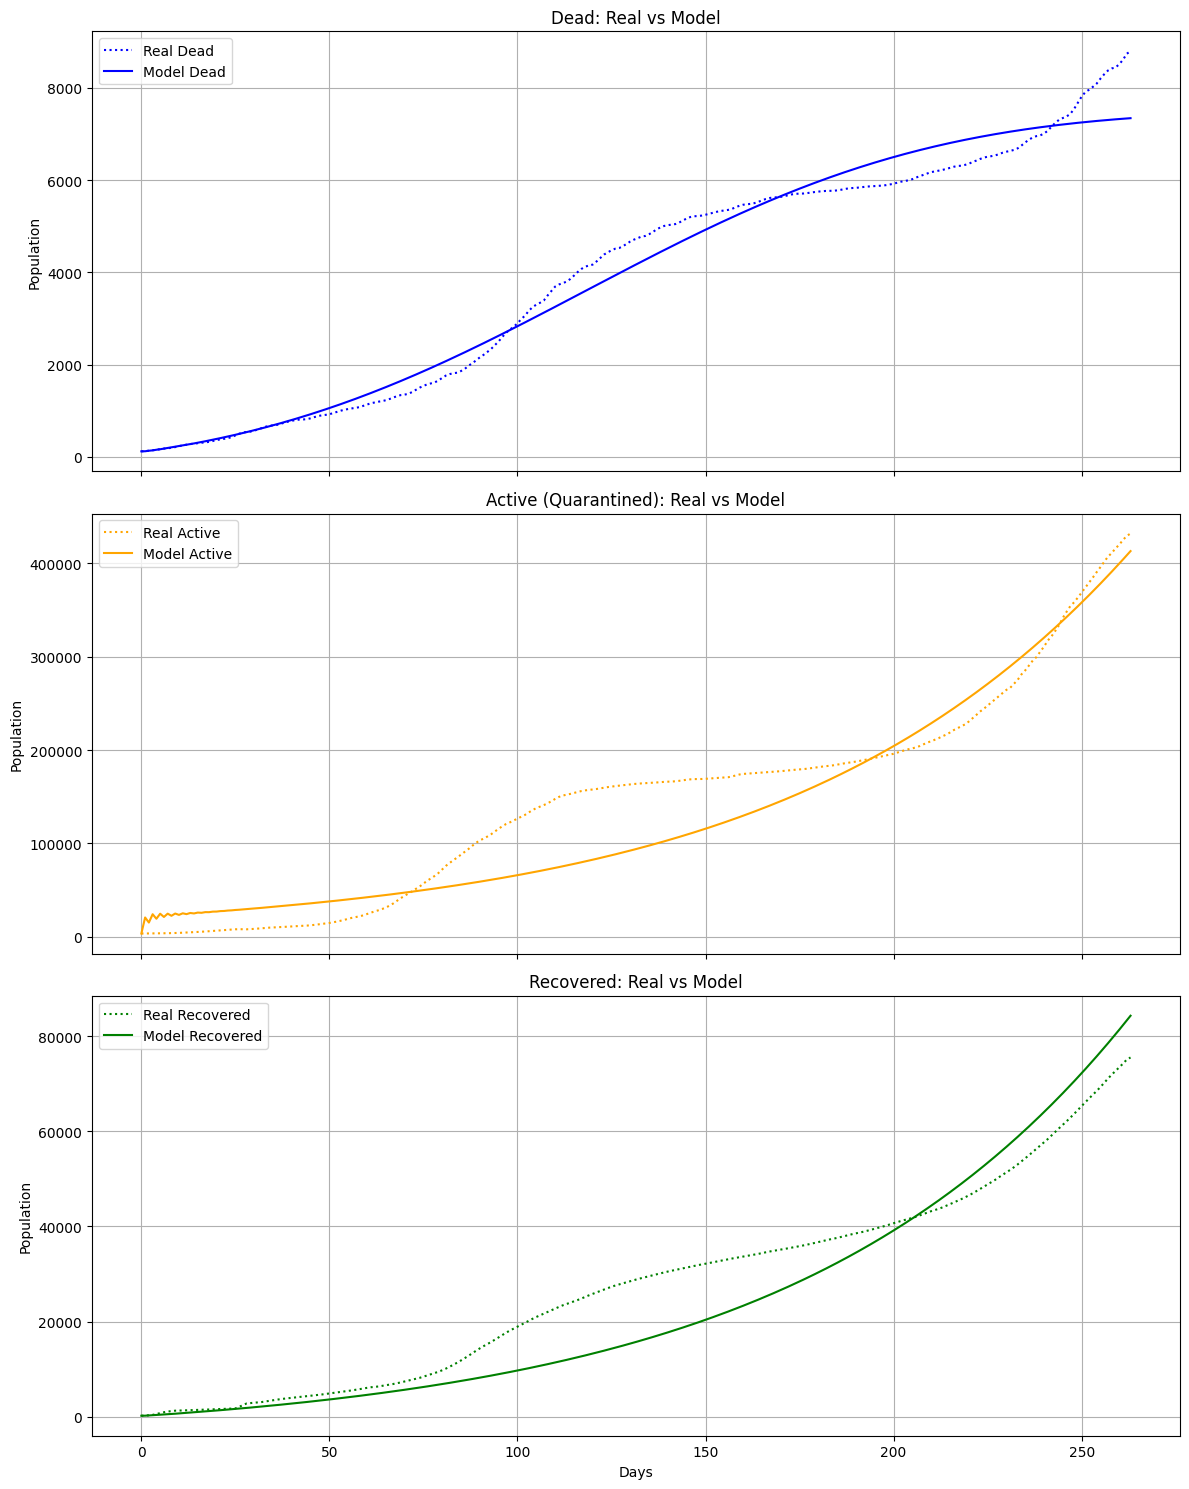

264
`ftol` termination condition is satisfied.
Function evaluations 98, initial cost 2.9848e+04, final cost 2.2827e+00, first-order optimality 7.03e-01.
E0: 1000 I0: 1000 Final cost: 2.282748574720462
`ftol` termination condition is satisfied.
Function evaluations 105, initial cost 2.9815e+04, final cost 2.2730e+00, first-order optimality 3.31e+01.
E0: 1000 I0: 1500 Final cost: 2.272987763144041
`xtol` termination condition is satisfied.
Function evaluations 29, initial cost 2.9831e+04, final cost 1.3147e+01, first-order optimality 9.94e+01.
E0: 1000 I0: 2000 Final cost: 13.146639169540206
`xtol` termination condition is satisfied.
Function evaluations 47, initial cost 2.9875e+04, final cost 2.4408e+00, first-order optimality 4.79e+03.
E0: 1000 I0: 2500 Final cost: 2.4407910363933287
`ftol` termination condition is satisfied.
Function evaluations 71, initial cost 2.9935e+04, final cost 2.2899e+00, first-order optimality 1.59e+02.
E0: 1000 I0: 3000 Final cost: 2.2899309227558997
`ftol` 

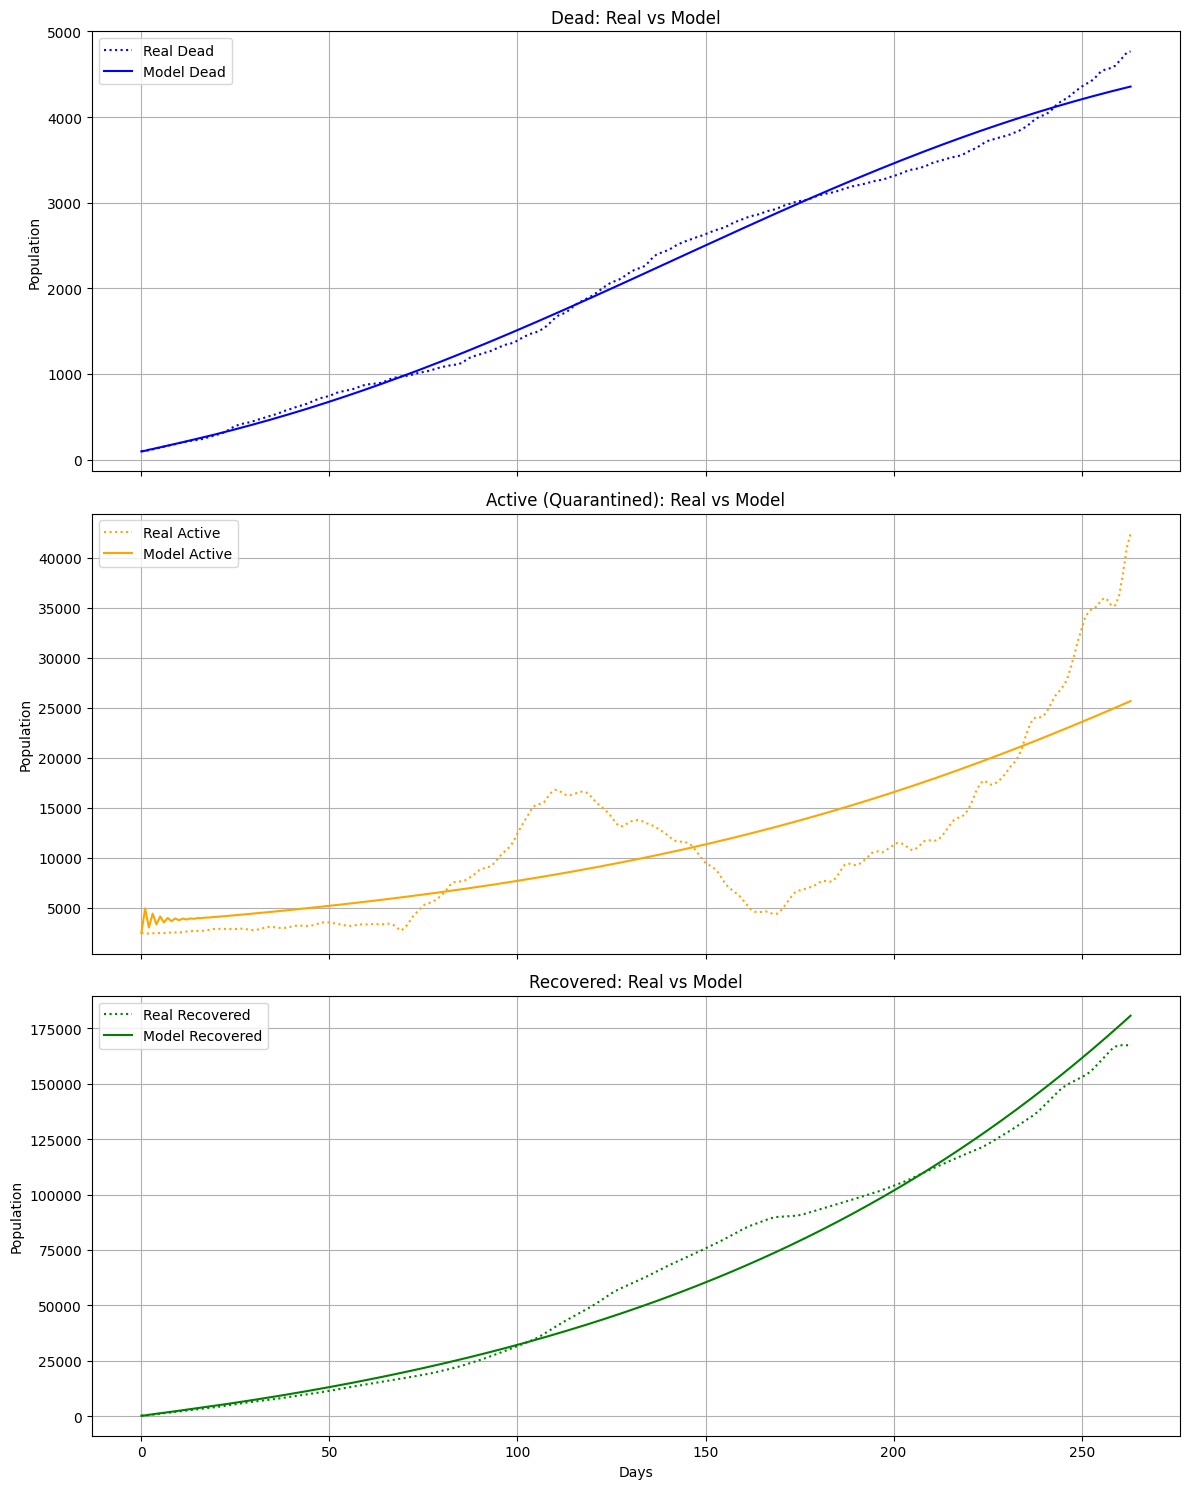

264
`ftol` termination condition is satisfied.
Function evaluations 59, initial cost 9.8704e+04, final cost 2.3395e+01, first-order optimality 1.04e+02.
E0: 1000 I0: 1000 Final cost: 23.395338202706927
`xtol` termination condition is satisfied.
Function evaluations 44, initial cost 9.9017e+04, final cost 2.3752e+01, first-order optimality 1.38e+03.
E0: 1000 I0: 1500 Final cost: 23.751720624271844
`xtol` termination condition is satisfied.
Function evaluations 65, initial cost 9.9404e+04, final cost 2.4894e+00, first-order optimality 7.15e+01.
E0: 1000 I0: 2000 Final cost: 2.489367003815635
`xtol` termination condition is satisfied.
Function evaluations 48, initial cost 9.9807e+04, final cost 3.2357e+00, first-order optimality 1.79e+02.
E0: 1000 I0: 2500 Final cost: 3.2357431023061896
`xtol` termination condition is satisfied.
Function evaluations 32, initial cost 1.0020e+05, final cost 2.7715e+01, first-order optimality 1.09e+04.
E0: 1000 I0: 3000 Final cost: 27.71517574461981
`xtol` t

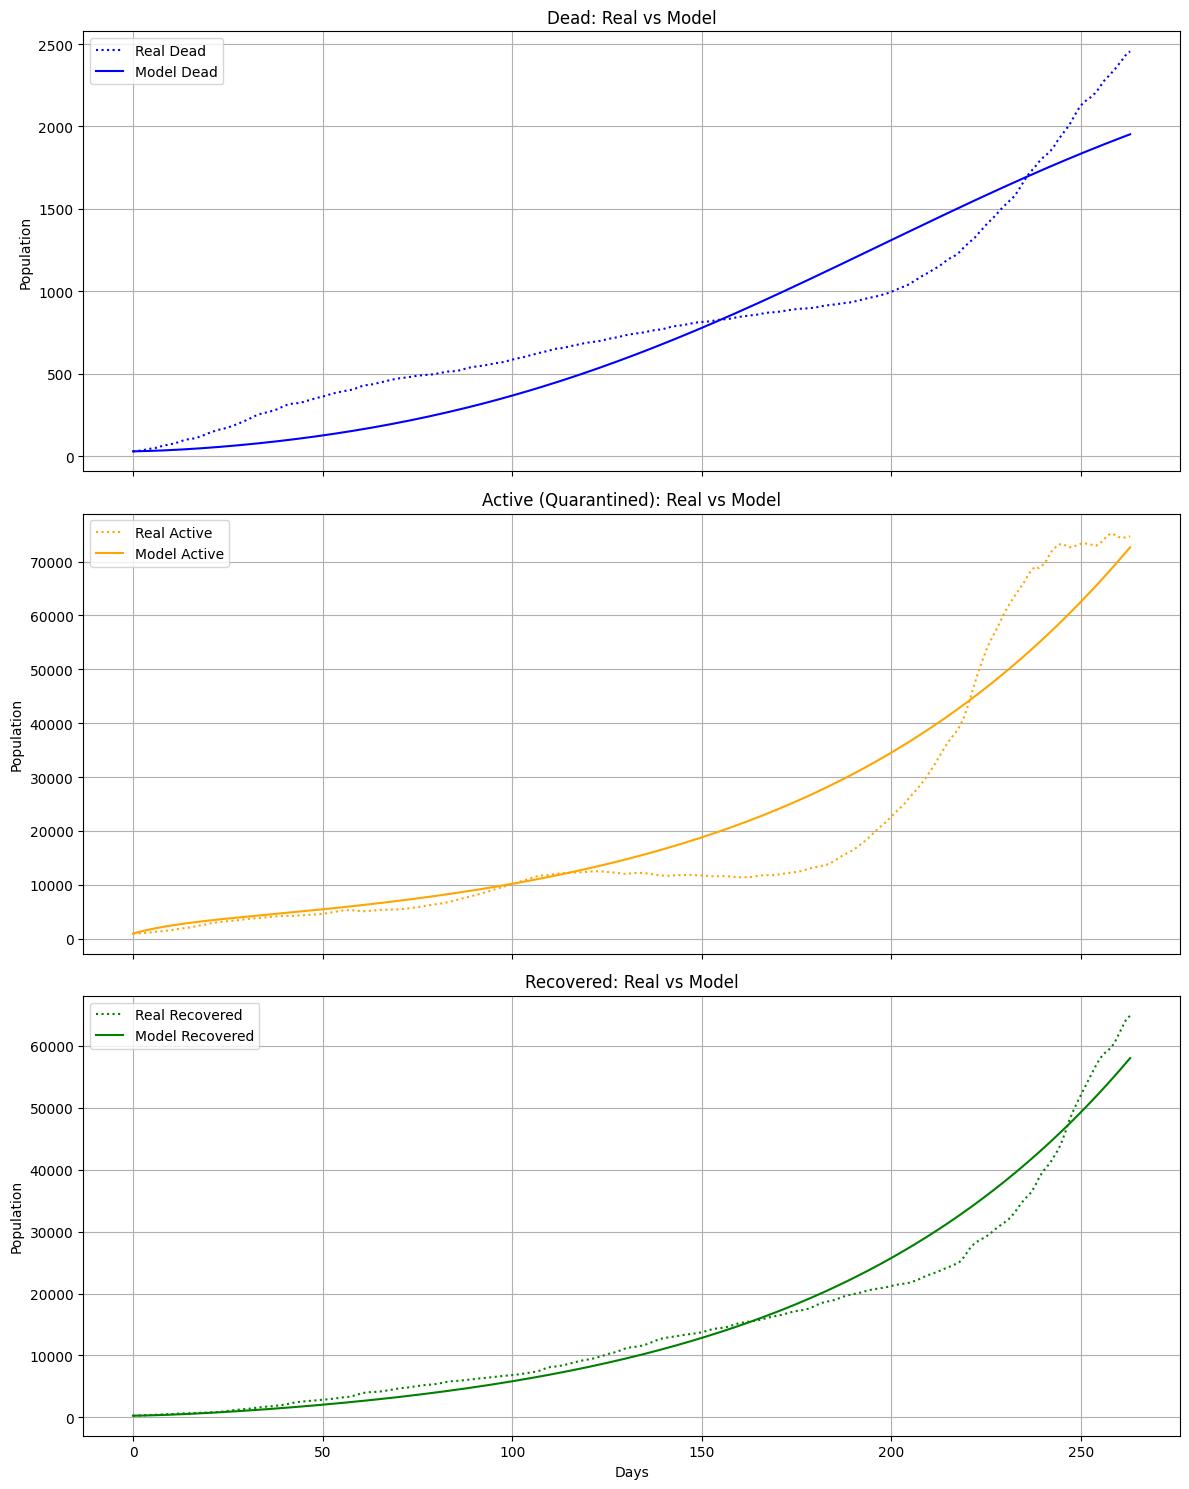

264
`xtol` termination condition is satisfied.
Function evaluations 47, initial cost 6.3662e+04, final cost 2.7911e+00, first-order optimality 2.25e+02.
E0: 1000 I0: 1000 Final cost: 2.791133328611659
`xtol` termination condition is satisfied.
Function evaluations 89, initial cost 6.1580e+04, final cost 1.9933e+00, first-order optimality 1.18e-02.
E0: 1000 I0: 1500 Final cost: 1.9933055323156148
`ftol` termination condition is satisfied.
Function evaluations 82, initial cost 5.9779e+04, final cost 1.9937e+00, first-order optimality 1.93e+00.
E0: 1000 I0: 2000 Final cost: 1.9936503652851087
`xtol` termination condition is satisfied.
Function evaluations 91, initial cost 5.8209e+04, final cost 1.9951e+00, first-order optimality 6.14e+00.
E0: 1000 I0: 2500 Final cost: 1.9951083013210136
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 59, initial cost 5.6830e+04, final cost 1.9991e+00, first-order optimality 1.52e+00.
E0: 1000 I0: 3000 Final cost: 1.999130

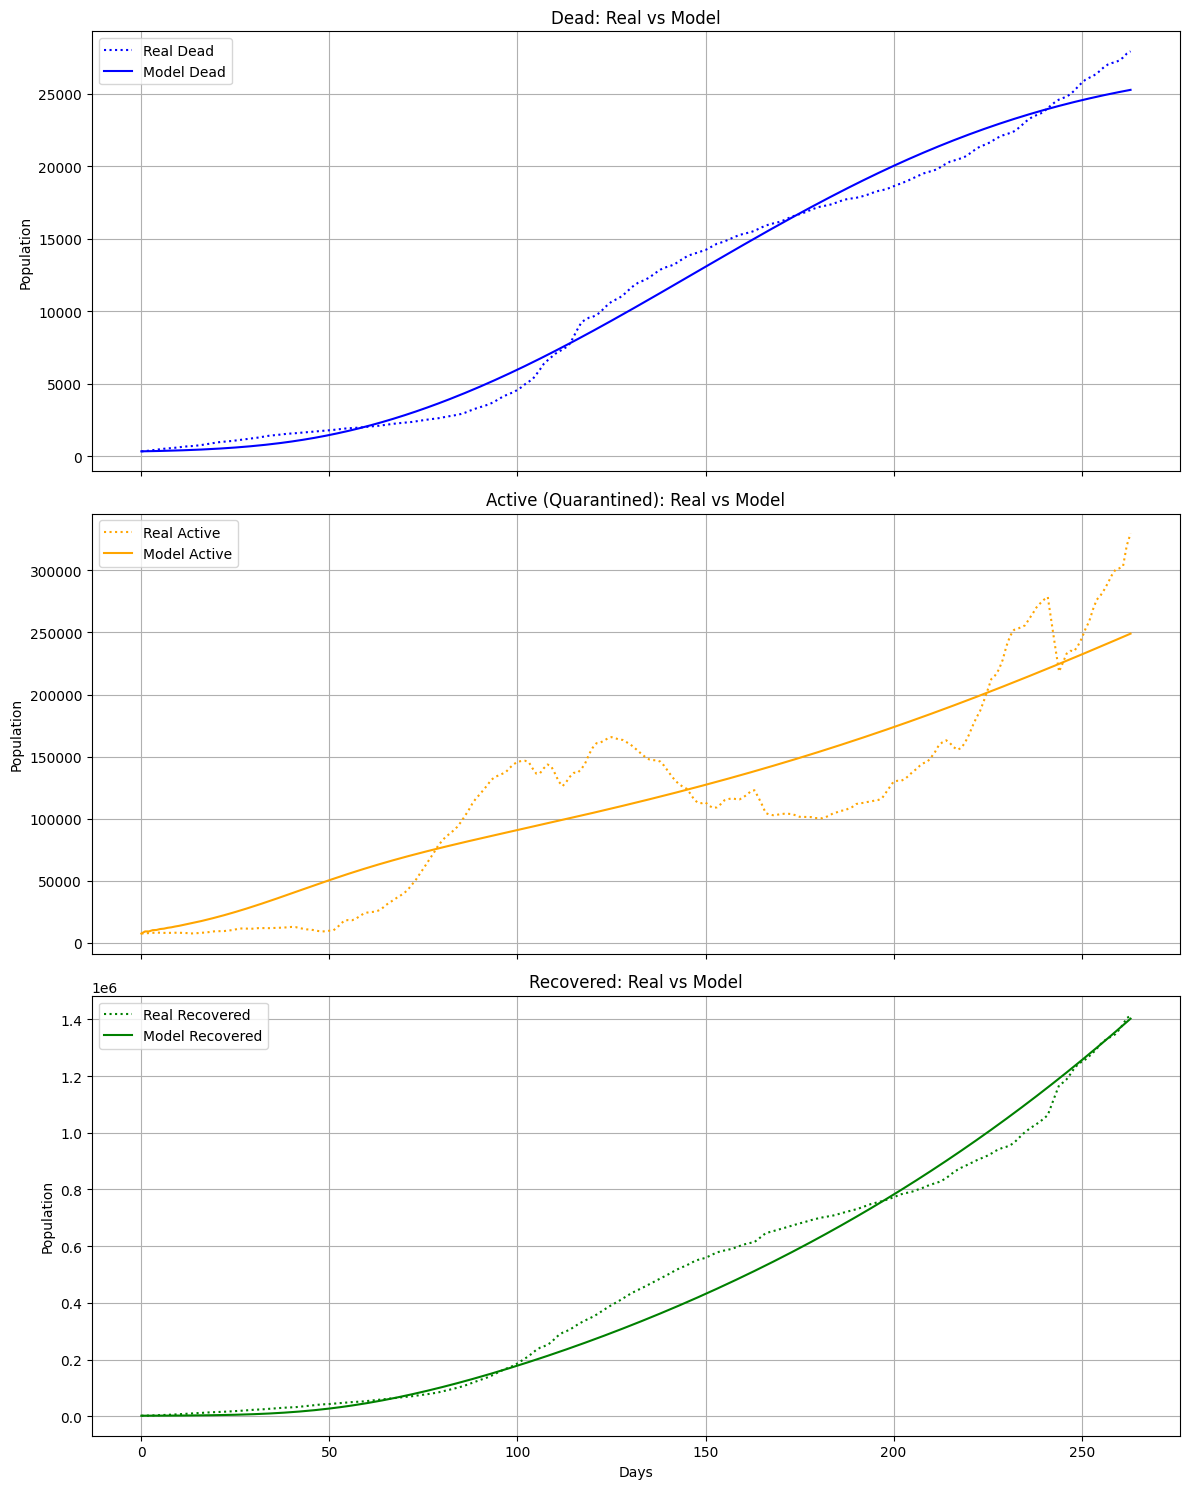

264
`ftol` termination condition is satisfied.
Function evaluations 43, initial cost 7.0045e+06, final cost 2.5190e+01, first-order optimality 2.32e+03.
E0: 1000 I0: 1000 Final cost: 25.189914162079845
`xtol` termination condition is satisfied.
Function evaluations 37, initial cost 7.0453e+06, final cost 2.5969e+01, first-order optimality 3.27e+01.
E0: 1000 I0: 1500 Final cost: 25.96920478845954
`xtol` termination condition is satisfied.
Function evaluations 20, initial cost 7.0821e+06, final cost 3.0857e+01, first-order optimality 1.85e+03.
E0: 1000 I0: 2000 Final cost: 30.856656593598213
`xtol` termination condition is satisfied.
Function evaluations 30, initial cost 7.1155e+06, final cost 2.7653e+01, first-order optimality 5.42e+02.
E0: 1000 I0: 2500 Final cost: 27.652944815680584
`xtol` termination condition is satisfied.
Function evaluations 23, initial cost 7.1461e+06, final cost 2.8802e+01, first-order optimality 4.94e+03.
E0: 1000 I0: 3000 Final cost: 28.802406230060356
`xtol` 

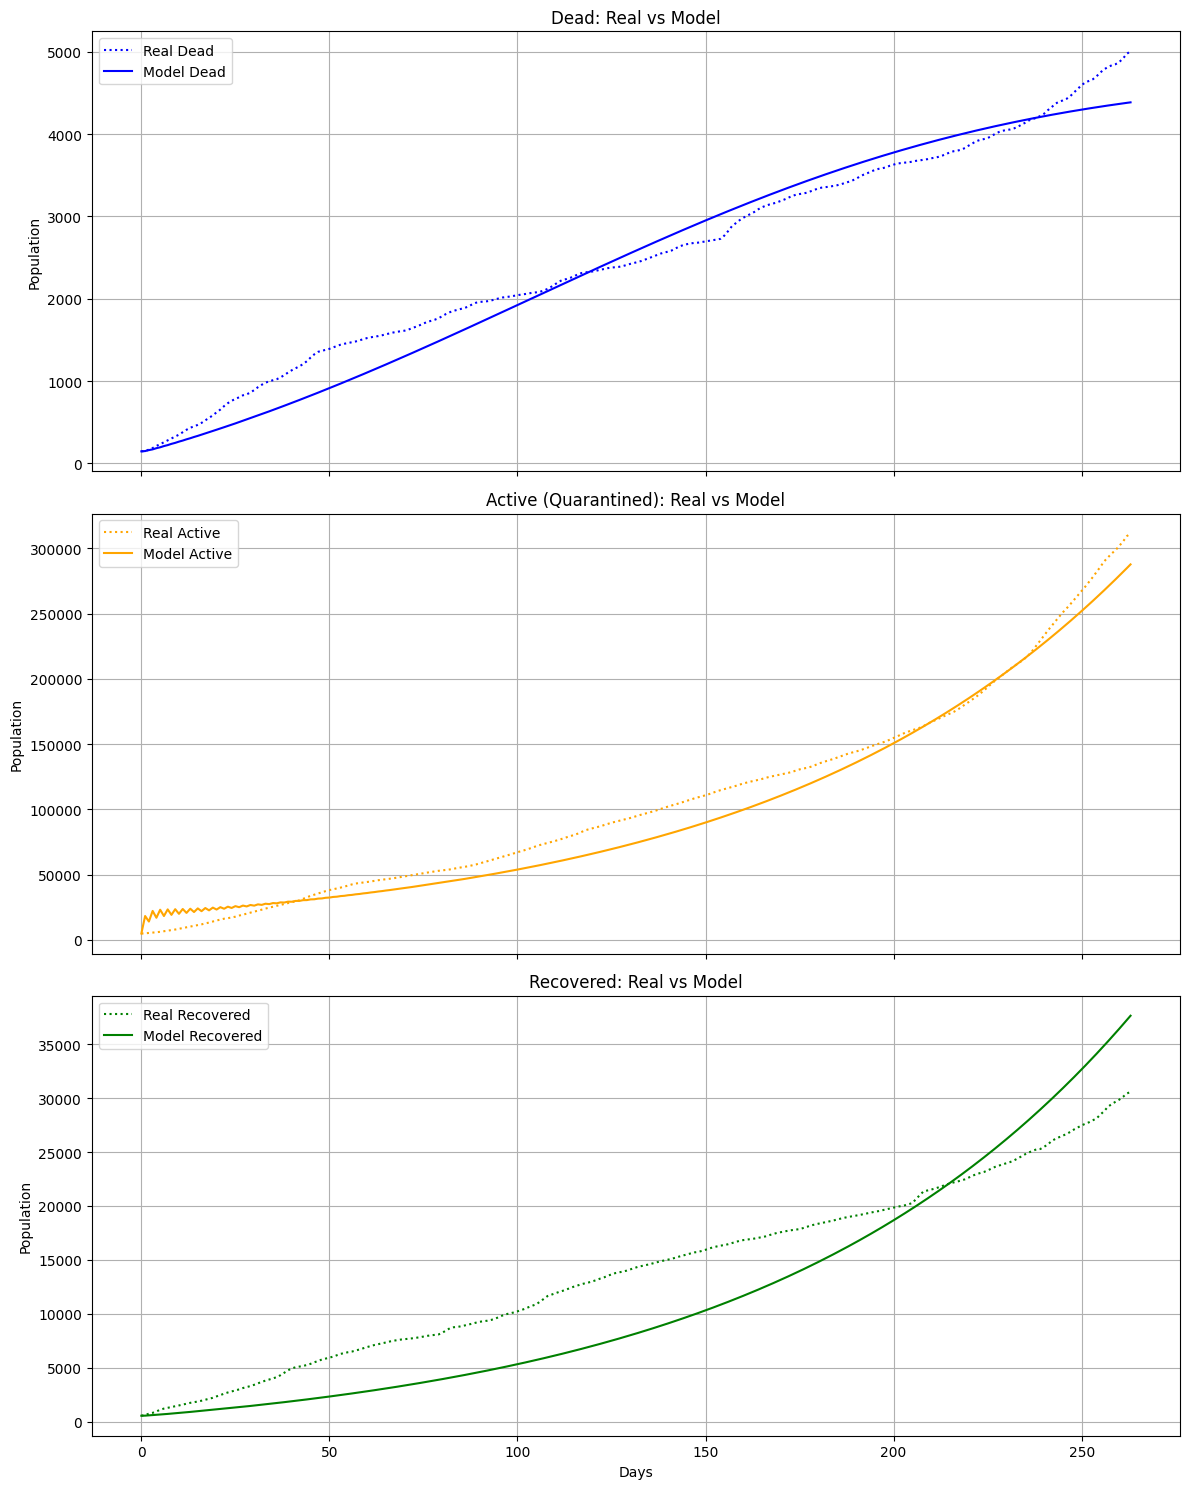

         State     alpha      beta     delta  \
0      arizona  0.500000  0.029286  1.812241   
1  mississippi  0.100000  0.143246  1.747473   
2   new mexico  0.100005  0.040216  0.100731   
3        texas  0.499151  0.106390  1.728406   
4     virginia  0.500000  0.024622  1.919460   

                                              Lambda  \
0  [0.004853539310671143, 3.2336157595440498e-34,...   
1  [0.12031413999314285, 4.091677733583899e-34, 1...   
2  [0.020051429661794427, 1.006709210034409e-06, ...   
3  [0.04700274929265288, 0.06360463116645779, 38....   
4  [0.002855664174451632, 3.2021837073627295e-34,...   

                                               Kappa    E0    I0  
0  [0.0007422702962652322, 0.009744336417991661, ...  9500  9500  
1  [0.002764726529152625, 0.006321041302226013, 4...  2000  1500  
2  [0.0006504026541390541, 0.007378284985842065, ...  1000  2000  
3  [0.0013714382040293852, 0.008997977130123219, ...  1500  1000  
4  [0.0006448167370002965, 0.0070292647

In [15]:
import pathlib
State_name = ['arizona', 'mississippi', 'new mexico', 'texas', 'virginia']
path = pathlib.Path().resolve()  #path = "D:\MyDownload\Code\OD-COVID\datasets"
para_summary = []
for i in range(len(State_name)):
    name = State_name[i]
    df = pd.read_csv(os.path.join(path, name + '_cases_0412_1231.csv'))
    print(len(df))
    #initial_conditions = [(9500,9500),(1000,9500),(1000,1000),(9500,9500),(1000, 1000)]  # Example initial conditions for E0 and I0
    #parameters, E0, I0 = fit_function(df, initial_conditions[i])
    parameters, E0, I0 = fit_function(df)
    plot_comparea(df, parameters, E0, I0)
    # 记录参数结果
    para_summary.append((name, *parameters, E0, I0))

# 生成DataFrame
para_df = pd.DataFrame(para_summary, columns=['State', 'alpha', 'beta', 'delta', 'Lambda', 'Kappa', 'E0', 'I0'])
print(para_df)

In [16]:
para_df.rename(columns={'Lambda': 'lambda', 'Kappa': 'kappa'}, inplace=True)
#para_df.to_csv('D:\MyDownload\Code\OD-COVID\datasets\seird_parameters_v1.csv', index=False)
para_df.to_csv(os.path.join(path, 'seird_parameters_step1_v2.csv'), index=False)